# Retail Price Recommendation
## Machine Learning Project by Daniel Weatherspoon

### Background
As the world progresses, more and more people are buying products from regular people than from the company that made the product themselves. This is becoming extremely common as the cost is often less than the retail price. On apps such as Facebook Marketplace, eBay, and Mercari, the person selling the product gets to choose to price to be whatever they want. It might be less or it might be way too high of a price. There are many factors people put into pricing their goods, like how important it is to them, how rare is this product now, what they personally think of the product value and more. In this machine learning project, we will build a model than can automatically suggest the right price for products. 

### Exploratory Data Analysis

In [155]:
# Imports
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import gc
import time
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

##### In The Dataset:
- train_id: The ID of the listing.
- name: The title of the listing.
- item_condition_id: Condition of the items provided by sellers.
- category_name: Category of listing.
- brand_name: Name of the brand.
- price: Price the item was sold for. This is our target variable.
- shipping: If shipping fee paid by seller, 1. If shipping paid by buyer, 0.
- item_description: Description of the item.

In [156]:
# Loading data
df = pd.read_csv('mercari_train.tsv', sep='\t')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [157]:
df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [159]:
# checking for any null values
print(df.isnull().sum())
print('Category name, brand name and item description are the columns with missing values. Brand name has almost all missing values.')

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          6
dtype: int64
Category name, brand name and item description are the columns with missing values. Brand name has almost all missing values.


In [160]:
df.price.describe() #price is the target variable

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [161]:
#warnings.filterwarnings('ignore')
# Filling missing values
df['brand_name'] = df['brand_name'].fillna('missing').astype(str)
df['item_description'] = df['item_description'].fillna('none').astype(str)
df['brand_name'] = df['brand_name'].astype("category")
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity


In [162]:
# Handling Categorical Variables
# Label Encoding
le = preprocessing.LabelEncoder()
df['category'] = le.fit_transform(df['category_name'])
df['brand'] = le.fit_transform(df['brand_name'])  # label encoding brand name
df['item_condition'] = le.fit_transform(df['item_condition_id'])
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category,brand,item_condition
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,808,4786,2
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,86,3557,2
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1254,4180,0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,485,4786,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,1181,4786,0


In [163]:
# clean up text features
def cleaning(column):
    # remove non-alphanumeric characters
    column = column.str.replace("[\W]", " ") #a-z, A-Z, 0-9
    # lowercase 
    #column = column.apply(lambda x: x.lower())
    return column

df['item_description'] = cleaning(df['item_description'])
df['name'] = cleaning(df['name'])
df['category_name'] = cleaning(df['category_name'])
df['brand_name'] = cleaning(df['brand_name'])

df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category,brand,item_condition
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,808,4786,2
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,86,3557,2
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1254,4180,0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,485,4786,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,1181,4786,0


In [164]:
mask = np.random.rand(len(df)) < 0.75
train = df[mask]
test = df[~mask] # ~mask is the opposite of mask
print(train.shape, test.shape)
train['price'].describe()

(1111804, 11) (370731, 11)


count    1.111804e+06
mean     2.671850e+01
std      3.837010e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [165]:
#Unique values
print('There are', train['category_name'].nunique(), 'unique values in category name')
train['category_name'].value_counts().head(10)

There are 1263 unique values in category name


category_name
Women/Athletic Apparel/Pants, Tights, Leggings                 45212
Women/Tops & Blouses/T-Shirts                                  34863
Beauty/Makeup/Face                                             25775
Beauty/Makeup/Lips                                             22445
Electronics/Video Games & Consoles/Games                       19923
Beauty/Makeup/Eyes                                             18906
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    18533
Women/Underwear/Bras                                           15986
Women/Tops & Blouses/Tank, Cami                                15298
Women/Tops & Blouses/Blouse                                    15244
Name: count, dtype: int64

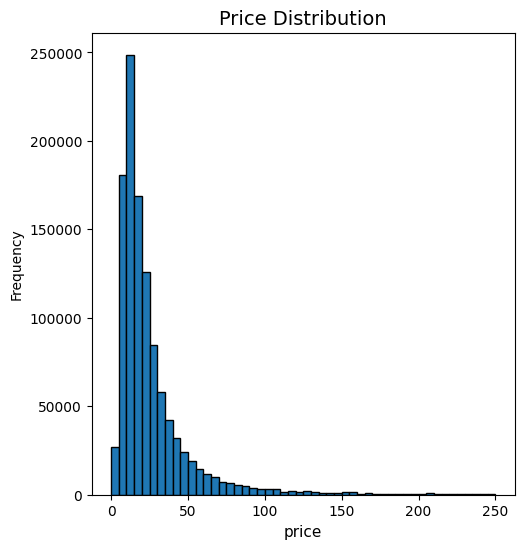

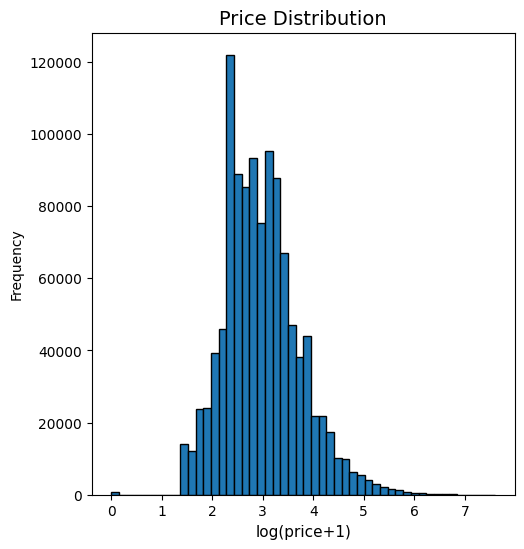

In [166]:
# Price Distribution 
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor='black', range=[0, 250])
plt.xlabel('price', fontsize=11)
plt.title('Price Distribution', fontsize=14)
plt.show()

#We can see that the price distribution is right skewed. We will apply log transformation to the price to make it normally distributed.

# Log transformation of price
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12, 6), edgecolor='black')
plt.xlabel('log(price+1)', fontsize=11)
plt.title('Price Distribution', fontsize=14)
plt.show()
# From the log transformation we can see that most prices are between 2 and 3.5. Which is equal to 7.39 and 33.11 in the original price scale.
# The log transformation of price makes it normally distributed. 
train['log_price'] = np.log(train['price']+1)

In [167]:
#Shipping 
print(train['shipping'].value_counts()/len(train))
#Remember, if shipping fee paid by seller, 1. If shipping paid by buyer, 0.
print('Just over 55% of the items have shipping paid by the buyer.')

shipping
0    0.552957
1    0.447043
Name: count, dtype: float64
Just over 55% of the items have shipping paid by the buyer.


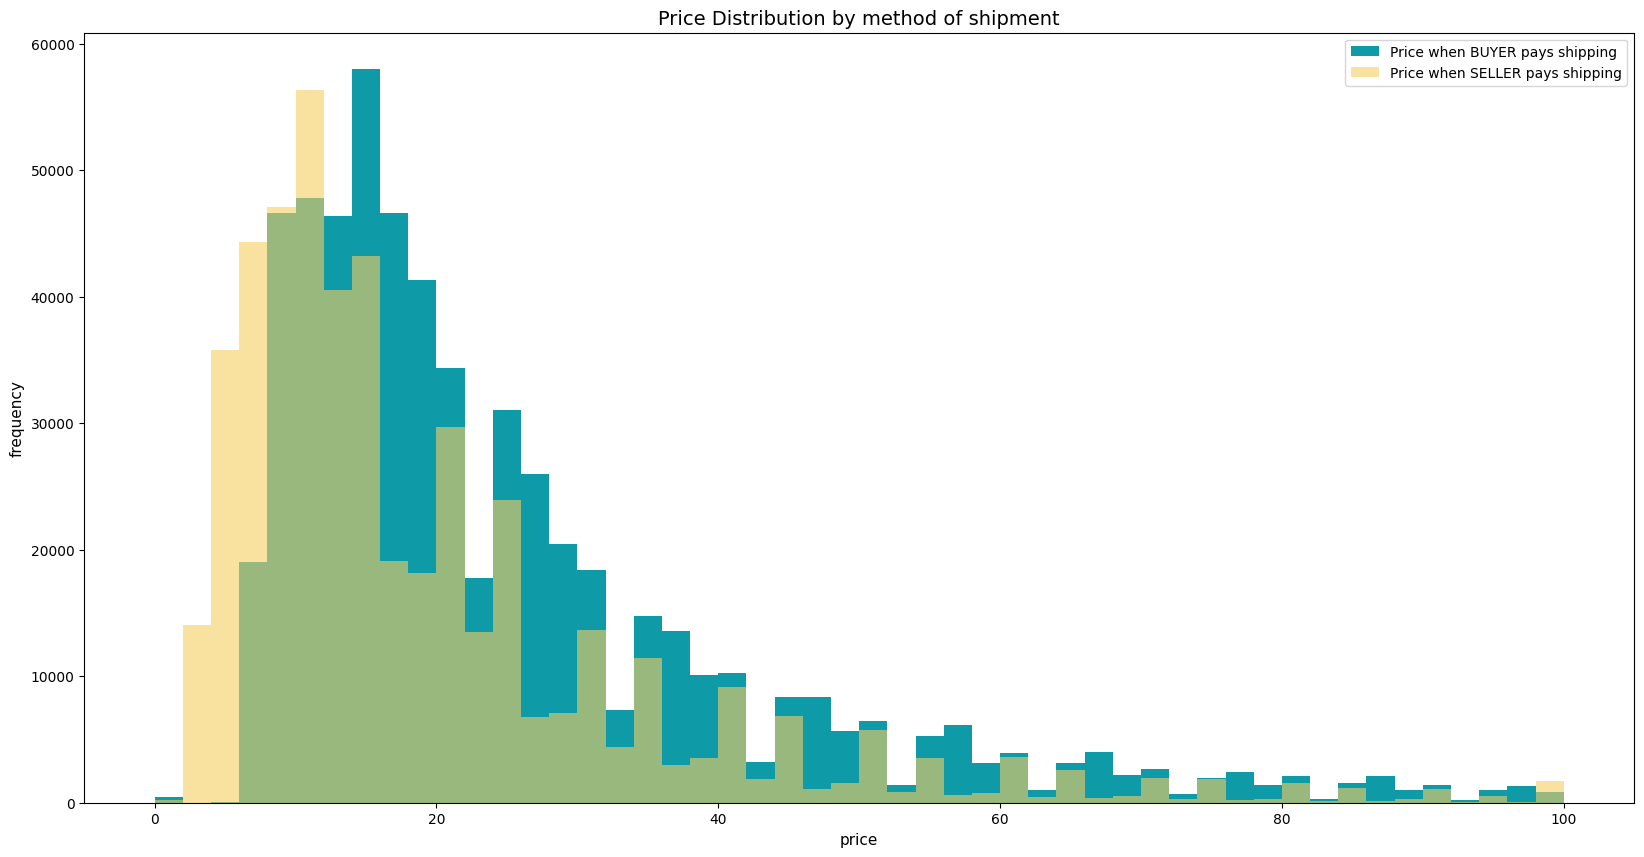

In [168]:
#Shipping relationship with price
ship_buyer = train.loc[train['shipping'] == 0, 'price']
ship_seller = train.loc[train['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(ship_buyer, color = '#0E9AA7', alpha = 1.0, bins = 50, range = [0, 100], label = 'Price when BUYER pays shipping')
ax.hist(ship_seller, color = '#F6CD61', alpha = 0.6, bins = 50, range = [0, 100], label = 'Price when SELLER pays shipping')
plt.xlabel('price', fontsize=11)
plt.ylabel('frequency', fontsize=11)   
plt.title('Price Distribution by method of shipment', fontsize=14)
plt.legend()
plt.show()

In [169]:
print('The average price is {}'.format(round(ship_buyer.mean(), 2)), 'if the buyer pays for shipping.')
print('The average price is {}'.format(round(ship_seller.mean(), 2)), 'if the seller pays for shipping.')
print('The difference in average price is {}'.format(round(ship_buyer.mean() - ship_seller.mean(), 2)), 'which is statistically significant.')

The average price is 30.07 if the buyer pays for shipping.
The average price is 22.57 if the seller pays for shipping.
The difference in average price is 7.5 which is statistically significant.


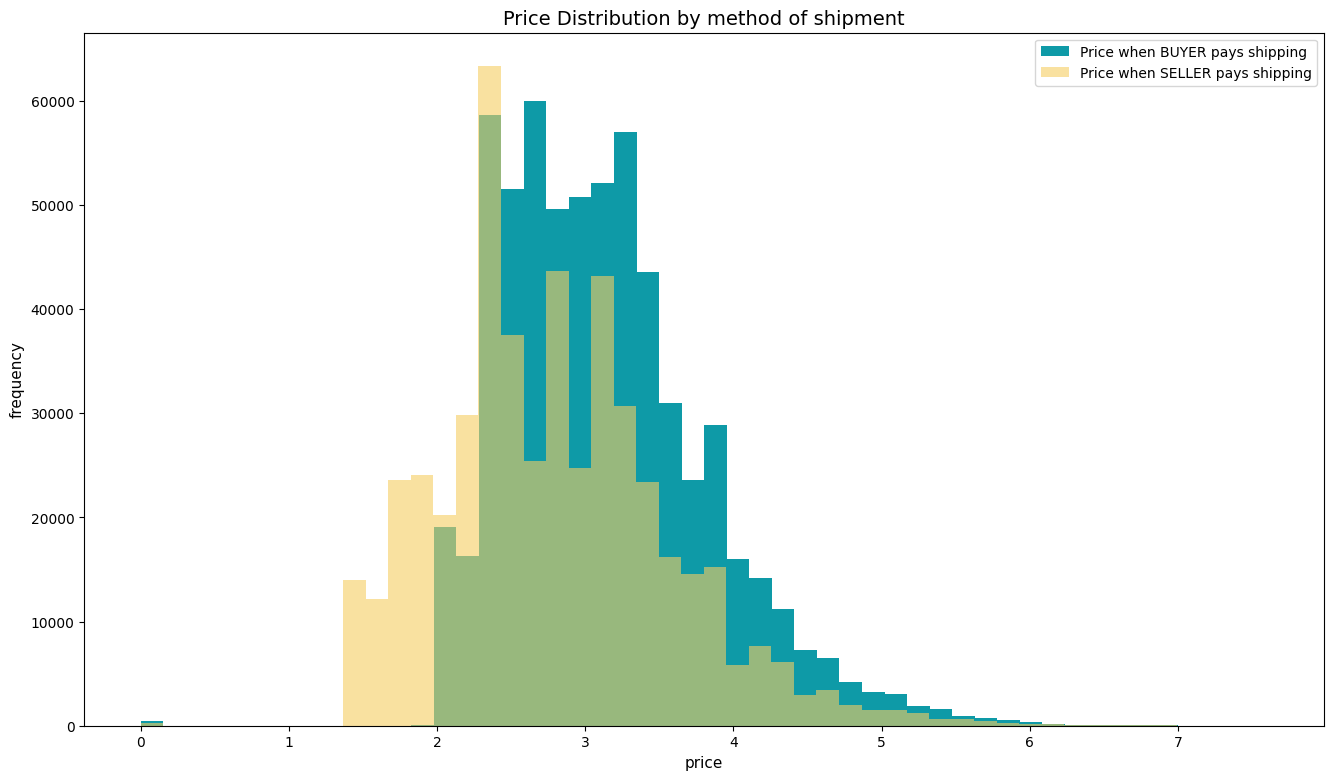

In [170]:
ship_buyer_log = np.log(ship_buyer+1)
ship_seller_log = np.log(ship_seller+1)
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(ship_buyer_log, color = '#0E9AA7', alpha = 1.0, bins = 50, label = 'Price when BUYER pays shipping')
ax.hist(ship_seller_log, color = '#F6CD61', alpha = 0.6, bins = 50, label = 'Price when SELLER pays shipping')
plt.xlabel('price', fontsize=11)
plt.ylabel('frequency', fontsize=11)   
plt.title('Price Distribution by method of shipment', fontsize=14)
plt.legend()
plt.show()
#The average price is higher if the buyer pays for shipping.

##### Item Condition vs. Price

The average price varies by item condition. The average price is highest for items in condition 1 and lowest for items in condition 4.


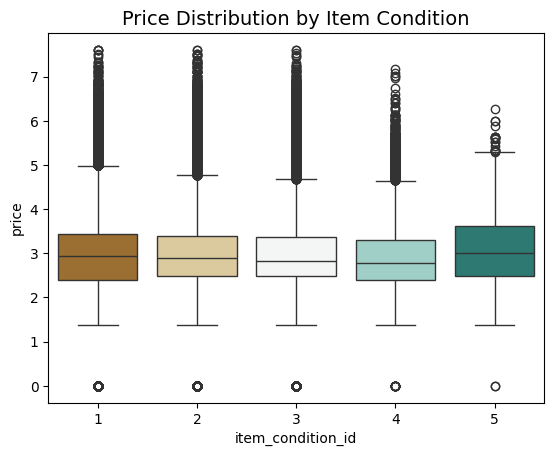

In [171]:
sns.boxplot(x = 'item_condition_id', y =  np.log(train['price']+1), data = train, palette = sns.color_palette('BrBG', 5))
plt.title('Price Distribution by Item Condition', fontsize=14)
print('The average price varies by item condition. The average price is highest for items in condition 1 and lowest for items in condition 4.')

### Model Selection & Training

In [174]:
X = train[['category', 'brand', 'item_condition', 'shipping']]
y = train['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
def model_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((833853, 4), (277951, 4), (833853,), (277951,))

#### Decision Trees Model

In [175]:
#Decision Tree Model
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
mse, r2 = model_score(dt, X_train, y_train, X_test, y_test)
print('Decision Tree Model')
print('Mean Squared Error:', mse) #Needs to be close to 0 (log = 0.32)
print('R2:', r2) #Needs to be close to 1 (log = 0.41)


Decision Tree Model
Mean Squared Error: 0.32867571541206814
R2: 0.4164134682841305


#### Random Forests Model

In [176]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
mse, r2 = model_score(rf, X_train, y_train, X_test, y_test)
print('Random Forest Model')
print('Mean Squared Error:', mse) #Needs to be close to 0 log = 0.31
print('R2:', r2) #Needs to be close to 1 log = 0.44


Random Forest Model
Mean Squared Error: 0.3160973623963208
R2: 0.4387472065767659


### Conclusion
- When it comes to finding the better recommended price, the Random Forests model predicts better, but at the expense of runtime. It took almost 2 minutes to complete, where the decision tree model took less than 2 seconds.